In [1]:
import mmh3 #library for Minhashing
import numpy as np
import pandas as pd
#import nltk
#from nltk.tokenize import word_tokenize
import mmh3   # Fast, non-cryptographic hash
#import math
#nltk.download('punkt')

In [13]:
def Get_word_shingles(text, q=1):
    """Return q-word shingles from pre-cleaned text using simple split."""
    #Ensure the text is always a string
    if not isinstance(text, str):
        text = "" if pd.isna(text) else str(text)
    
    #split the text in words
    words = text.split()
    
    #if text has less than q words return all text in 1 shingle
    if len(words) < q:
        return [" ".join(words)]  # single shingle if too short
    
    #create shingles of q words
    return [" ".join(words[i:i+q]) for i in range(len(words) - q + 1)]

def base_hash(shingle):
    """Convert a shingle in number applying a basic hash function (MurmurHash3 from package mmh3.hash) """
    return np.uint32(mmh3.hash(shingle, signed=False))

def Minhash_signature(shingles,num_hashes,hash_space):
    """Return Minhash siganture for a set of shingles"""
    
    #Uses base_hash function to convert the vector of shingles in numbers
    hash_values_shingles = np.array([base_hash(s) for s in shingles], dtype=np.uint64)
    
    #define a new set of hash functions for Minhashing 
    #hash function: h_i(x) = (a_i * x + b_i) mod max_hash
    np.random.seed(42)  #set seed to ensure reproducibility
    a = np.random.randint(1, hash_space, size=num_hashes, dtype=np.uint64)
    b = np.random.randint(0, hash_space, size=num_hashes, dtype=np.uint64)

    #create a vector to store the signature 
    signature = np.full(num_hashes, np.inf)
    
    for i in range(num_hashes):
        #apply each hash functions h_i to the hash_values (set of shingles converted in numbers)
        h_i_values = (a[i] * hash_values_shingles + b[i]) % hash_space
        #for each hash function take the minimum between the h_i_values
        signature[i]=h_i_values.min()

    return signature.astype(np.uint32)



In [9]:
def Minhashing(reviews,q, num_hashes, hash_space):
    """
    Returns MinHash signatures for a dataset of text reviews.

    This function converts each review into a set of q-grams (substrings of length q),
    then applies multiple hash functions to create MinHash signatures.

    Args:
        reviews (list[str]): A list of text strings (reviews) to process.
        q (int): The number of words of each  shingle used to tokenize the reviews.
        num_hashes (int): The number of hash functions (signature vector size).
        hash_space (int): The size of the hash value space.

    Returns:
        list[list[int]]: A list where each element is the MinHash signature
        (a list of integers) corresponding to one review.
    """
    
    #Create empty lists to store signatures for all the reviews
    signatures = []

    #Create signature for each review
    for review in reviews:    
        
        #get a vector of shingles from the review
        shingles = Get_word_shingles(review, q=q)
        #get the signature vector using Minhashing
        signature = Minhash_signature(shingles,num_hashes,hash_space)
    
        
        signatures.append(signature)
    
    return signatures

In [4]:
#get dataset
data=pd.read_csv("/Users/sararedaelli/Desktop/AMAZON REVIEWS/Books_rating_cleaned_minhashing2.csv")


In [5]:
data.columns

Index(['Id', 'review/score', 'cleanText', 'lang'], dtype='object')

In [14]:
#choice of parameters 
q=1 #number of words of each shingle used to tokenize the reviews
num_hashes=100 #number of hash functions (signature vector size)
hash_space= 2**32-1 #size of the hash value space

#get Minhash signatures vector form the text reviews
signatures=Minhashing(data['cleanText'],q,num_hashes,hash_space)
ratings=data['review/score']
#create pd dataframe which contains two columns: rating scores and signatures
minhashing = pd.DataFrame({
    
    'signature': signatures,
    'rating': ratings,
})


In [22]:
minhashing['signature'][1]

array([   551439,  28708638,  10915333,  58190910,  27862493,  27036402,
        42023208,   3748147,   2112544,  69414687,  77420227,  21890889,
        30544122,  29636516,  14142847,   2747720,  49855985,   8294151,
        33725638,  37530772,   9757249,  53404033,  36712255,  20405108,
          532255,  38840223,   3999093, 114748902,   2539471,  58281536,
        98991260,  41736202,   3343334,   9952145,   7572940,  12969113,
        35122076,  51425083,  29903822,   9393153,    536531,  14530533,
        14662239,  14904219,  92789729,   8268911,  25372853,  17770998,
         7819692,   3724246,    933329,  51364972,  25950122, 152886418,
         5296366,  54428057,  19842102,  25661143,   2639538,  34117369,
        13114928,  81430267,    530467,  66028987,  54322513,  41387591,
        20753574,   4968670,  11031346,  12006161,   3081895,  47013074,
        29168183,  25235135,  21283239,  65692384,  10351391,  57957396,
         1504110,   1390792,  22480088,  10313768, 

In [18]:
minhashing.shape

(2968263, 2)

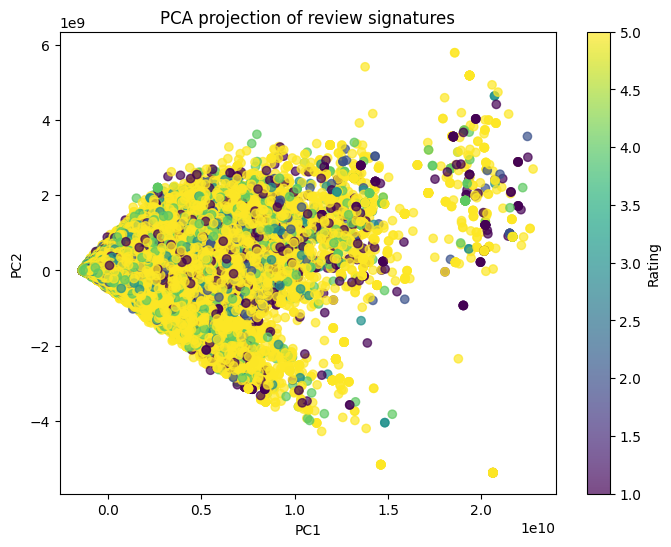

In [16]:
# Convert list of lists into 2D array
X = np.vstack(minhashing['signature'].values)
y = minhashing['rating'].values  # for coloring points
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2, random_state=42)
reduced = pca.fit_transform(X)

plt.figure(figsize=(8,6))
sc = plt.scatter(reduced[:,0], reduced[:,1], c=y, cmap='viridis', alpha=0.7)
plt.colorbar(sc, label='Rating')
plt.title('PCA projection of review signatures')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()